# 1112決策支援 Titanic分析

##1.連接雲端並前往指定資料夾

In [1]:
#連接雲端(工作階段要設為GPU)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#前往 指定資料夾
%cd '/content/drive/MyDrive/中原/1112課程/決策支援與商業智慧/期末報告/titanic_data'

/content/drive/MyDrive/中原/1112課程/決策支援與商業智慧/期末報告/titanic_data


##2.資料前處理










1.  讀入 train dataset 及 test dataset
2.  欄位刪除 資料合併
3.  查看各項指標

In [3]:
# 載入必要模組
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

# 讀入 train dataset 及 test dataset
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# 看看其維度(Train有12個欄位891 records，Test則有11個欄位418 records)
print('train.shape = ',train.shape)
print('test.shape = ',test.shape)

# Survived欄位是該乘客是否倖存，這也是我們最終要預測的結果值，因此把該欄位從train dataset移出成為一個獨立的Y_label dataset。
Y_label = train.Survived
train.drop(labels='Survived', axis=1, inplace=True)

# 將Test dataset置於train dataset之後，複製成新的dataset x_train。
x_train = pd.concat([train, test])
print('x_train.shape = ',x_train.shape)

# 列出dataset所有的欄位名稱
print('x_train.columns.values = ',x_train.columns.values)

train.shape =  (891, 12)
test.shape =  (418, 11)
x_train.shape =  (1309, 11)
x_train.columns.values =  ['PassengerId' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch' 'Ticket' 'Fare'
 'Cabin' 'Embarked']


In [4]:
# 顯示前五筆記錄的內容，NaN為 Null，代表該筆無此資料（缺值）。
print('x_train.head()')
x_train.head()

x_train.head()


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
#Describe()指令可概觀整個dataset以掌握資料的範圍分佈，並找出那個欄位有缺值（空值）。理論上每個欄位都應該有1309筆，但Age欄位僅1046筆，可見該欄位少了263筆資料，Fare欄位有1308筆看來少了一筆，我們稍後需要處理此問題。
print('x_train.describe()')
x_train.describe()

x_train.describe()


,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,2.294882,29.881138,0.498854,0.385027,33.295479
std,378.020061,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,3.000000,80.000000,8.000000,9.000000,512.329200


In [6]:
#Info()指令可顯示所有欄位的格式。我們從中得知float64有2個，int64有5個，object類型有5個
print('x_train.info()')
x_train.info()

x_train.info()
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Pclass       1309 non-null   int64  
 2   Name         1309 non-null   object 
 3   Sex          1309 non-null   object 
 4   Age          1046 non-null   float64
 5   SibSp        1309 non-null   int64  
 6   Parch        1309 non-null   int64  
 7   Ticket       1309 non-null   object 
 8   Fare         1308 non-null   float64
 9   Cabin        295 non-null    object 
 10  Embarked     1307 non-null   object 
dtypes: float64(2), int64(4), object(5)
memory usage: 122.7+ KB


In [7]:
#檢視非數值欄位：include=[‘O’]參數可針對Object類型欄位進行統計。執行後發現count=1309，unique=1307，Name欄位有兩筆是重複的名字。Sex欄位只有兩種Male/Female，其中以Male最多有843位。
x_train.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,1309,1309,1309,295,1307
unique,1307,2,929,186,3
top,"Connolly, Miss. Kate",male,CA. 2343,C23 C25 C27,S
freq,2,843,11,6,914


##3.資料分析 & 圖表展現

###各年齡層的男女比例

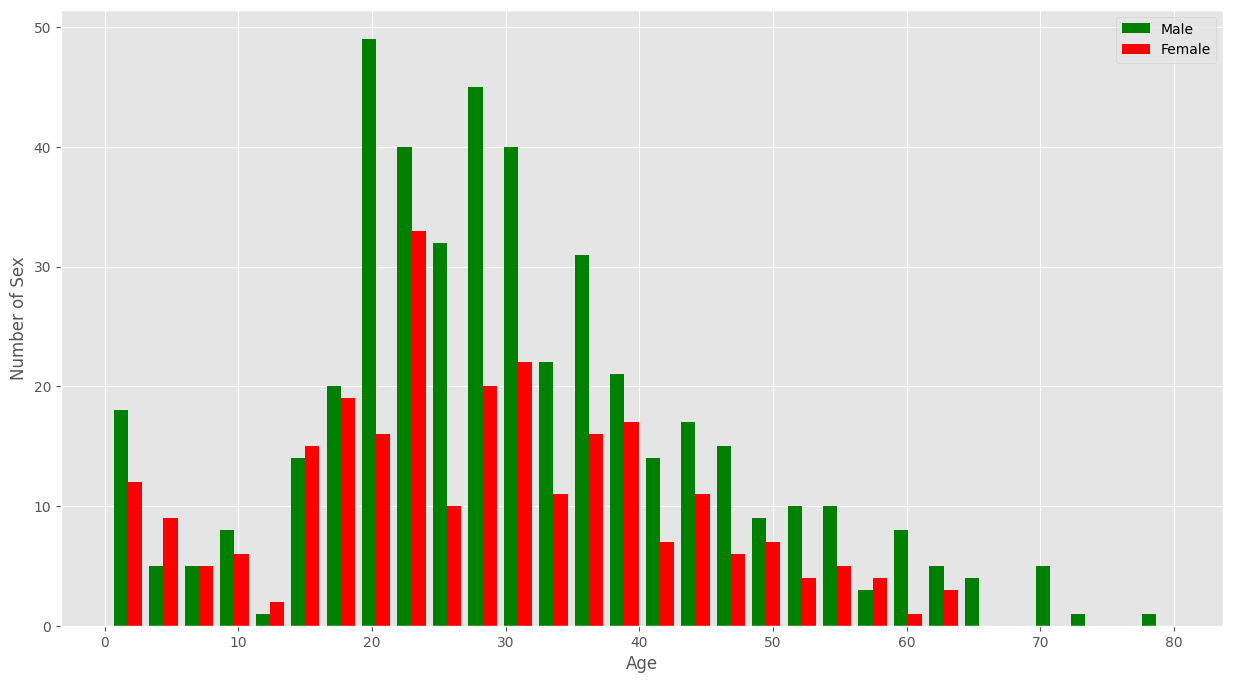

In [8]:
#船上的乘客各年齡層的男女比例
#小於20歲的男女人數比例接近，但若超過20歲（含）的乘客，則男性比例為女性的2倍。
figure = plt.figure(figsize=(15,8))
plt.hist([train[train['Sex']=='male']['Age'], train[train['Sex']=='female']['Age']], stacked=False, color = ['g','r'], bins = 30,label = ['Male','Female'])
plt.xlabel('Age')
plt.ylabel('Number of Sex')
plt.legend()

###以人數來看不同性別的倖存率

In [9]:
#以人數來看不同性別的倖存率
#以下pandas指令統計出乘客性別與倖存的比率，發現男性的倖存比率只有0.18，而女性高達0.74。
train = pd.concat([train, Y_label], axis=1)
train[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


<Axes: >

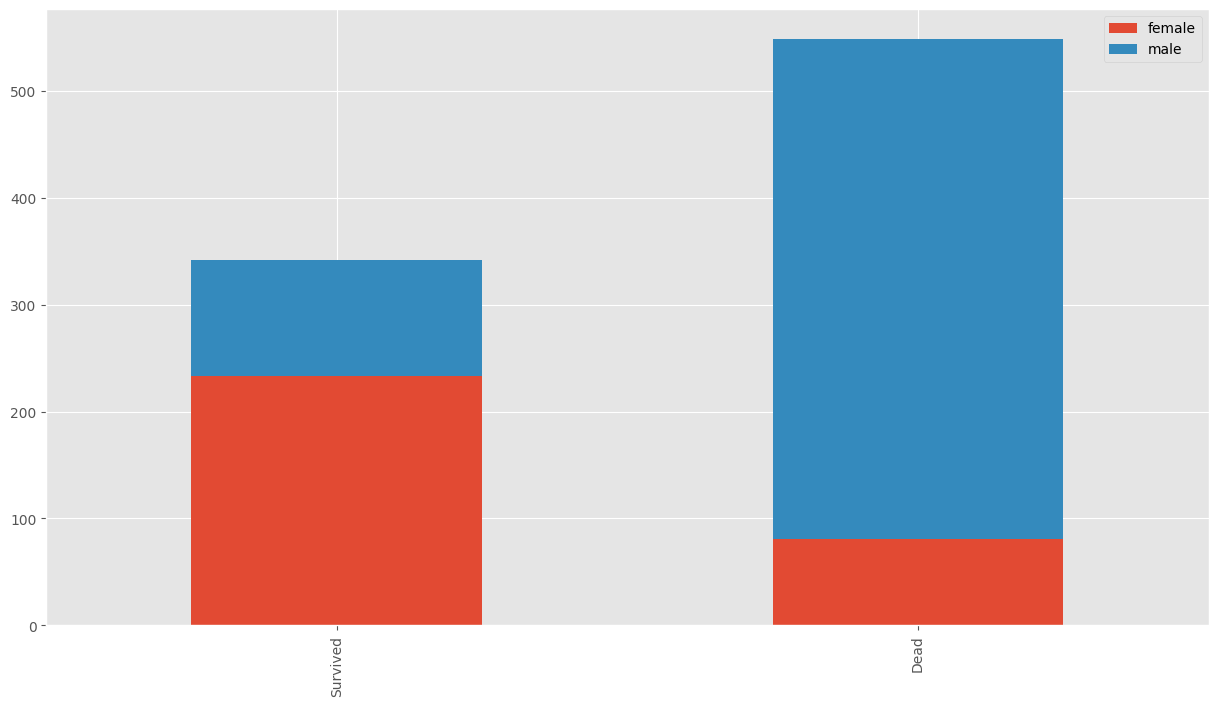

In [10]:
#以圖形化方式顯示，藍/紅分別代表男性與女性，左側bar為存活數，右側為死亡數
survived_sex = train[train['Survived']==1]['Sex'].value_counts()
dead_sex = train[train['Survived']==0]['Sex'].value_counts()
df = pd.DataFrame([survived_sex,dead_sex])
df.index = ['Survived','Dead']
df.plot(kind='bar',stacked=True, figsize=(15,8))

<Axes: >

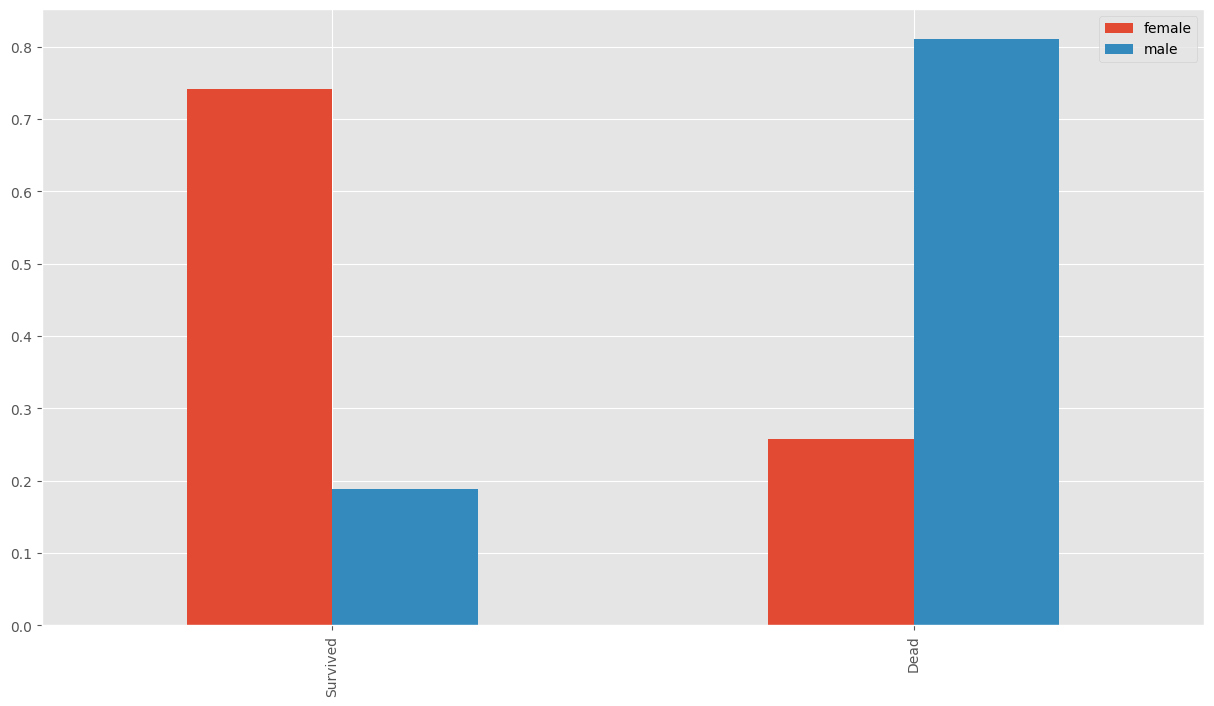

In [11]:
#以人數比例來看不同性別的倖存率
#用比例來看，則男性只有不到2成生存的機會，女性則超過8成有機會生存
total_sex = train['Sex'].value_counts()
p_survived_sex = train[train['Survived']==1]['Sex'].value_counts() / total_sex
p_dead_sex = train[train['Survived']==0]['Sex'].value_counts() / total_sex
df = pd.DataFrame([p_survived_sex,p_dead_sex])
df.index = ['Survived','Dead']
df.plot(kind='bar',stacked=False, figsize=(15,8))


###船票等級與存活的關係

<Axes: >

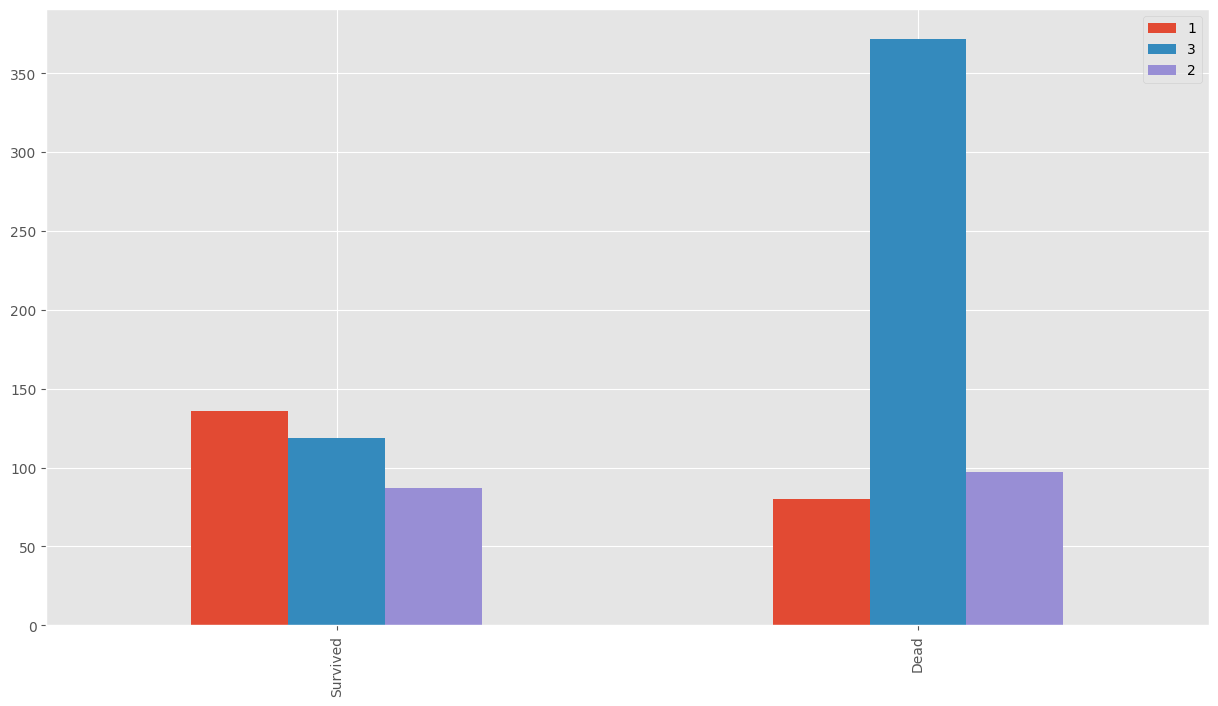

In [12]:
#船票等級與存活的關係(從人數來看不同船票等級的存活率)
#明顯看出等級3的乘客最多，死亡者也大部份為等級3的乘客。
survived_pclass = train[train['Survived']==1]['Pclass'].value_counts()
dead_pclass = train[train['Survived']==0]['Pclass'].value_counts()
df = pd.DataFrame([survived_pclass,dead_pclass])
df.index = ['Survived','Dead']
df.plot(kind='bar',stacked=False, figsize=(15,8))

In [13]:
#船票等級與存活的關係(機率來看各Pclass的存活比率)
#明顯看出等級3的乘客最多，死亡者也大部份為等級3的乘客。
train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [14]:
#不知為何int64全都變成float64？代解決
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Pclass       891 non-null    int64  
 2   Name         891 non-null    object 
 3   Sex          891 non-null    object 
 4   Age          714 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Ticket       891 non-null    object 
 8   Fare         891 non-null    float64
 9   Cabin        204 non-null    object 
 10  Embarked     889 non-null    object 
 11  Survived     891 non-null    int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


###不同年齡層與倖存的關係

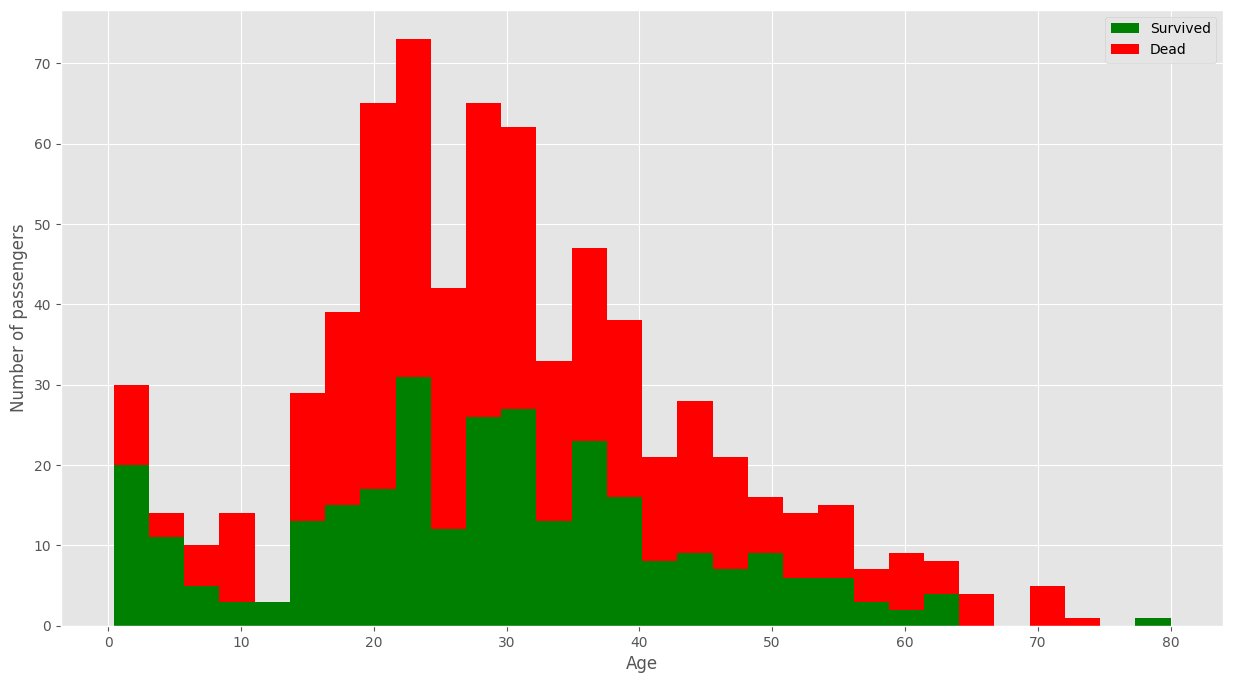

In [15]:
#不同年齡層與倖存的關係
#從下圖可看出年齡愈偏向兩極（較年長或較年幼）則存活率愈高，其中尤以年齡愈小愈明顯。
figure = plt.figure(figsize=(15,8))
plt.hist([train[train['Survived']==1]['Age'], train[train['Survived']==0]['Age']], stacked=True, color = ['g','r'],
bins = 30,label = ['Survived','Dead'])
plt.xlabel('Age')
plt.ylabel('Number of passengers')
plt.legend()

###不同票價與存活的關係

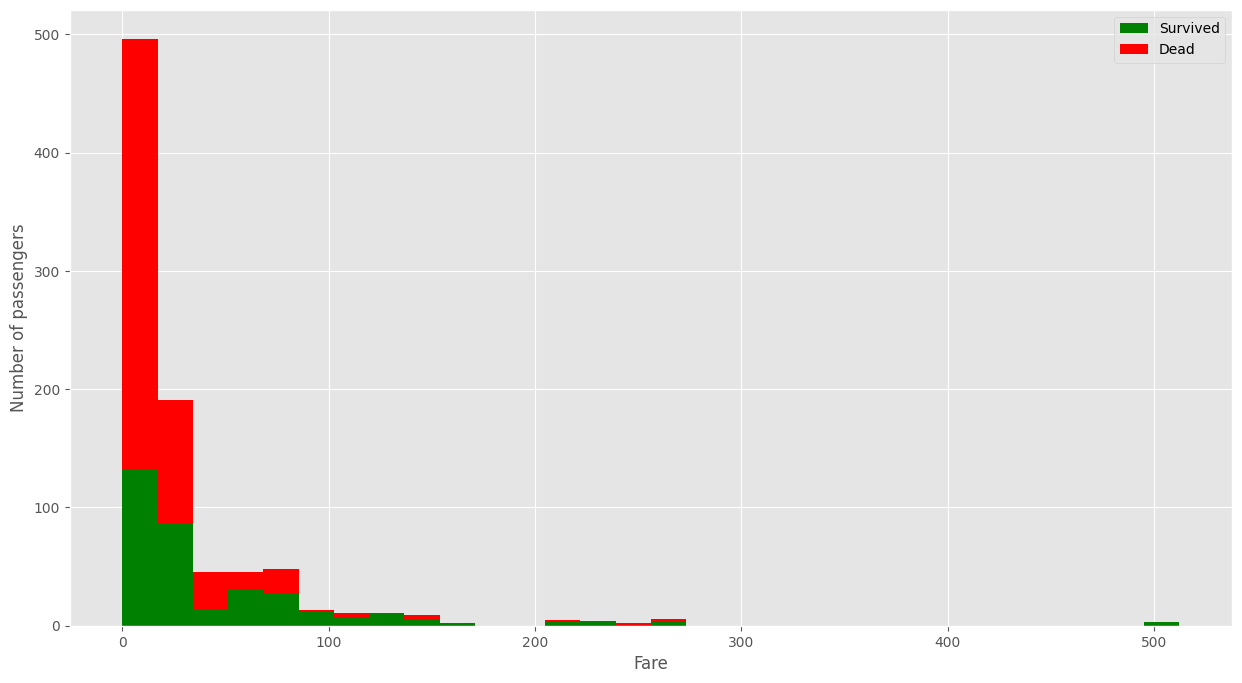

In [16]:
#不同票價與存活的關係
#票價愈高則存活率愈大
figure = plt.figure(figsize=(15,8))
plt.hist([train[train['Survived']==1]['Fare'], train[train['Survived']==0]['Fare']], stacked=True, color = ['g','r'],
bins = 30,label = ['Survived','Dead'])
plt.xlabel('Fare')
plt.ylabel('Number of passengers')
plt.legend()

###親屬人數對於存活率的影響

In [17]:
#親屬人數對於存活率的影響
#將SibSp與Parch這兩個欄位相加作為親屬人數來與存活率比較。經由下方的統計，可發現親屬人數為3人時有最高的存活率，其次為2人、１人以及6人
train['Family'] = train['SibSp'] + train['Parch']
train[['Family', 'Survived']].groupby(['Family'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Family,Survived
3,3,0.724138
2,2,0.578431
1,1,0.552795
6,6,0.333333
0,0,0.303538
4,4,0.200000
5,5,0.136364
7,7,0.000000
8,10,0.000000


###上岸港口與存活率的關係

In [18]:
#上岸港口與存活率的關係
#上岸港口的不同會影響到最終的倖存率嗎？很有趣的，從下方的統計看出，如果您是從Cherbourg上船，那麼恭喜您的存活率有5成5，如果從Queenstown上船那存活率降到3成8，從Southampton呢？那存活率只有3成3了。
train[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957
